# Similarity scores

## Imports

In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%autoreload 2

In [16]:
import itertools
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from kinsim_structure.encoding import Fingerprint
from kinsim_structure.similarity import calculate_similarity

## IO paths

In [17]:
PATH_TO_DATA = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
PATH_TO_KINSIM = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'

path_to_similarities = PATH_TO_KINSIM / 'results' / 'similarity'

## Functions

In [18]:
def get_allxall_scores(filename):
    
    return pd.read_csv(
        path_to_similarities / filename, 
        index_col=0
    )

In [19]:
def add_kinase_name(allxall_scores):
    
    allxall_scores['kinase1'] = allxall_scores['molecule1'].apply(lambda x: x[6:].split('_')[0])
    allxall_scores['kinase2'] = allxall_scores['molecule2'].apply(lambda x: x[6:].split('_')[0])
    
    return allxall_scores

In [20]:
def boxplot_scores(allxall_scores, fingerprint_type, score_type):
    
    boxplot = allxall_scores[
        'score score_physchem score_spatial'.split()
    ].plot.box(
        ylim=(0, 1),
        title=f'Scores for {fingerprint_type} using {score_type}: {len(allxall_scores)}'
    )
    
    boxplot.get_figure().savefig(
        path_to_similarities / f'similarity_scores_fp_{fingerprint_type}_{score_type}.png', 
        dpi=300
    )
    
    return boxplot
    

In [45]:
def get_max_scores(aaa):
    best_kinase_pairs = aaa[['kinase1', 'kinase2', 'score']].groupby(by=['kinase1', 'kinase2']).max()
    return best_kinase_pairs

In [21]:
def boxplot_max_scores(allxall_scores, fingerprint_type, score_type):
    
    allxall_scores_max = allxall_scores.groupby(by=['kinase1', 'kinase2'])['score'].max()

    boxplot = allxall_scores_max.plot(
        kind='box',
        title=f'Number of pairs: {len(allxall_scores_max)}',
        ylim=(0, 1)
    )
    
    return boxplot

In [22]:
def get_similarity_matrix(aaa, fingerprint_type, score_type):
    
    best_kinase_pairs = aaa[['kinase1', 'kinase2', 'score']].groupby(by=['kinase1', 'kinase2']).max()
    
    best_kinase_pairs = best_kinase_pairs.unstack(level=1)
    best_kinase_pairs.columns = best_kinase_pairs.columns.droplevel()
    
    # Fill lower matrix
    for index1, row in best_kinase_pairs.iterrows():
        for index2, element in row.items():
            if np.isnan(element):
                best_kinase_pairs.loc[index1, index2] = best_kinase_pairs.loc[index2, index1]
    
    print(best_kinase_pairs.shape)
    
    best_kinase_pairs.to_csv(
        path_to_similarities / f'best_scores_{fingerprint_type}_{score_type}.csv'
    )
    
    return best_kinase_pairs

## Load all-against-all scores

In [34]:
aaa_type1_ballester = get_allxall_scores('scores_allxall_fp_type1_ballester.csv')
aaa_type1_eucl = get_allxall_scores('scores_allxall_fp_type1_euclidean.csv')
aaa_type2_ballester = get_allxall_scores('scores_allxall_fp_type2_ballester.csv')

/home/dominique/anaconda3/envs/kinsim/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
aaa_type1_ballester = add_kinase_name(aaa_type1_ballester)
aaa_type1_eucl = add_kinase_name(aaa_type1_eucl)
aaa_type2_ballester = add_kinase_name(aaa_type2_ballester)

In [36]:
aaa_type1_ballester.head()

,molecule1,molecule2,score,score_physchem,score_spatial,coverage,coverage_physchem,coverage_spatial,kinase1,kinase2
0,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/AAK1_5l4q_altA_chainA,0.981337,0.973312,0.989362,NaN,0.991176,1.000000,AAK1,AAK1
1,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/AAK1_5te0_chainA,0.979958,0.972574,0.987343,NaN,0.991176,1.000000,AAK1,AAK1
2,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2f4j_chainA,0.912680,0.849466,0.975893,NaN,0.985294,1.000000,AAK1,ABL1
3,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2g1t_chainA,0.908688,0.846886,0.970490,NaN,0.985294,1.000000,AAK1,ABL1
4,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2g2i_chainA,0.912977,0.849495,0.976460,NaN,0.952941,0.964706,AAK1,ABL1


## Score distribution

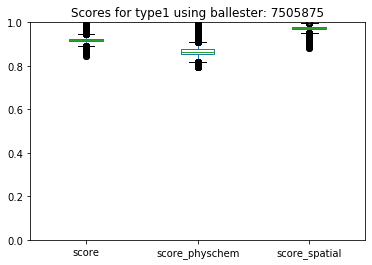

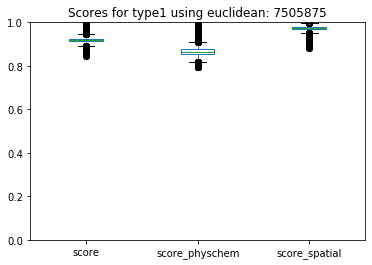

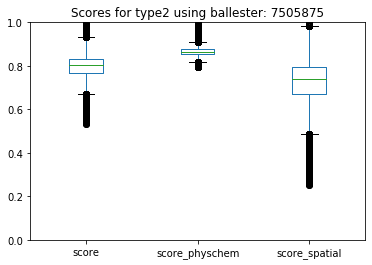

In [26]:
boxplot_aaa_type1_ballester = boxplot_scores(aaa_type1_ballester, 'type1', 'ballester')
boxplot_aaa_type1_eucl = boxplot_scores(aaa_type1_eucl, 'type1', 'euclidean')
boxplot_aaa_type2_ballester = boxplot_scores(aaa_type2_ballester, 'type2', 'ballester')

## Adapt Ballester scoring

In [37]:
aaa_type2_ballester.head()

,molecule1,molecule2,score,score_physchem,score_spatial,coverage,coverage_physchem,coverage_spatial,kinase1,kinase2
0,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/AAK1_5l4q_altA_chainA,0.940327,0.973312,0.907342,NaN,0.991176,1.0,AAK1,AAK1
1,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/AAK1_5te0_chainA,0.926509,0.972574,0.880445,NaN,0.991176,1.0,AAK1,AAK1
2,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2f4j_chainA,0.783110,0.849466,0.716753,NaN,0.985294,1.0,AAK1,ABL1
3,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2g1t_chainA,0.781358,0.846886,0.715830,NaN,0.985294,1.0,AAK1,ABL1
4,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2g2i_chainA,0.764343,0.849495,0.679191,NaN,0.952941,1.0,AAK1,ABL1


In [32]:
aaa_type2_normballester = aaa_type2_ballester.copy()

In [33]:
aaa_type2_normballester['score_physchem'] = (aaa_type2_normballester.score_physchem - 0.5) * 2

In [39]:
aaa_type2_normballester['score'] = 0.5 * aaa_type2_normballester.score_physchem + 0.5 * aaa_type2_normballester.score_spatial

In [91]:
aaa_type2_normballester

,molecule1,molecule2,score,score_physchem,score_spatial,coverage,coverage_physchem,coverage_spatial,kinase1,kinase2,score_physchem_norm
0,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/AAK1_5l4q_altA_chainA,0.926983,0.946623,0.907342,NaN,0.991176,1.00,AAK1,AAK1,0.946623
1,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/AAK1_5te0_chainA,0.912796,0.945147,0.880445,NaN,0.991176,1.00,AAK1,AAK1,0.945147
2,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2f4j_chainA,0.707843,0.698932,0.716753,NaN,0.985294,1.00,AAK1,ABL1,0.698932
3,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2g1t_chainA,0.704800,0.693771,0.715830,NaN,0.985294,1.00,AAK1,ABL1,0.693771
4,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2g2i_chainA,0.689090,0.698989,0.679191,NaN,0.952941,1.00,AAK1,ABL1,0.698989
5,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2gqg_altB_chainA,0.709205,0.699137,0.719273,NaN,0.985294,1.00,AAK1,ABL1,0.699137
6,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2hz4_chainB,0.734878,0.706440,0.763317,NaN,0.932353,0.75,AAK1,ABL1,0.706440
7,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_2v7a_chainB,0.703890,0.703319,0.704462,NaN,0.985294,1.00,AAK1,ABL1,0.703319
8,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL1_4twp_chainB,0.701246,0.702721,0.699772,NaN,0.985294,1.00,AAK1,ABL1,0.702721
9,HUMAN/AAK1_4wsq_altA_chainB,HUMAN/ABL2_2xyn_altA_chainA,0.702604,0.703015,0.702194,NaN,0.985294,1.00,AAK1,ABL2,0.703015


In [92]:
aaa_type2_normballester.to_csv(path_to_similarities / 'scores_allxall_type2_normballester.csv')

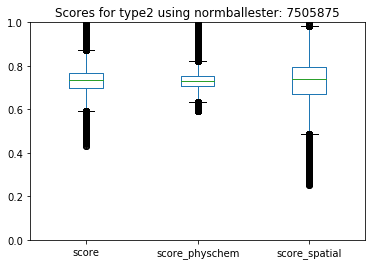

In [93]:
boxplot_aaa_type2_modballester = boxplot_scores(aaa_type2_normballester, 'type2', 'normballester')

## Best score per kinase pair

In [68]:
best_aaa_type2_ballester = get_max_scores(aaa_type2_ballester)
best_aaa_type2_normballester = get_max_scores(aaa_type2_normballester)

In [69]:
a = best_aaa_type2_ballester.sort_values(by='score', ascending=False)
b = best_aaa_type2_normballester.sort_values(by='score', ascending=False)

In [73]:
a['indexA'] = range(0, len(a))
b['indexB'] = range(0, len(b))

In [78]:
a.rename(columns={'score': 'scoreA'}, inplace=True)
b.rename(columns={'score': 'scoreB'}, inplace=True)

In [80]:
c = a.join(b)

In [84]:
(c.indexA - c.indexB).sort_values()

kinase1  kinase2
Haspin   PDK1       -5701
EGFR     RNAseL     -5578
Haspin   JAK1-b     -5517
         TYK2-b     -5353
         MAP2K7     -5285
                    ...  
MLK1     MLK4       10916
MST4     YSK1       11839
KIT      PDGFRb     12478
ErbB2    ErbB2      13191
PLK4     PLK4       13306
Length: 32063, dtype: int64

In [89]:
c.iloc[
    (c.index.get_level_values(0) == 'MLK1') &
    (c.index.get_level_values(1) == 'MLK4')
]

,,scoreA,indexA,scoreB,indexB
kinase1,kinase2,,,,
MLK1,MLK4,0.82721,16279,0.807107,5363


In [61]:
a.rename(columns={'kinase1': 'kinase1A', 'kinase2': 'kinase2A', 'score': 'scoreA'}, inplace=True)

In [63]:
b.rename(columns={'kinase1': 'kinase1B', 'kinase2': 'kinase2B', 'score': 'scoreB'}, inplace=True)

In [66]:
c = pd.concat([a, b], axis=1)
c.head()

,kinase1A,kinase2A,scoreA,kinase1B,kinase2B,scoreB
0,SRC,SRC,1.000000,MET,MET,1.000000
1,p110g,p110g,1.000000,p110g,p110g,1.000000
2,MET,MET,1.000000,SRC,SRC,1.000000
3,CDC2,CDC2,1.000000,CDC2,CDC2,1.000000
4,TGFbR1,TGFbR1,0.999729,TGFbR1,TGFbR1,0.999729


In [67]:
c[
    (c.kinase1A != c.kinase1B) &
    (c.kinase2A != c.kinase2B)
]

,kinase1A,kinase2A,scoreA,kinase1B,kinase2B,scoreB
0,SRC,SRC,1.000000,MET,MET,1.000000
2,MET,MET,1.000000,SRC,SRC,1.000000
7,CDK2,CDK2,0.994912,EphB4,EphB4,0.993880
8,AurA,AurA,0.994807,CDK2,CDK2,0.993410
9,EphB4,EphB4,0.994722,AurA,AurA,0.993401
10,PIM1,PIM1,0.994492,DYRK1A,DYRK1A,0.992730
11,DYRK1A,DYRK1A,0.994174,PIM1,PIM1,0.992680
17,PKACa,PKACa,0.992148,Haspin,Haspin,0.990709
18,AMPKa2,AMPKa2,0.991943,PKACa,PKACa,0.990644
19,Haspin,Haspin,0.991811,AMPKa2,AMPKa2,0.990399


## Plot best scoring pairs

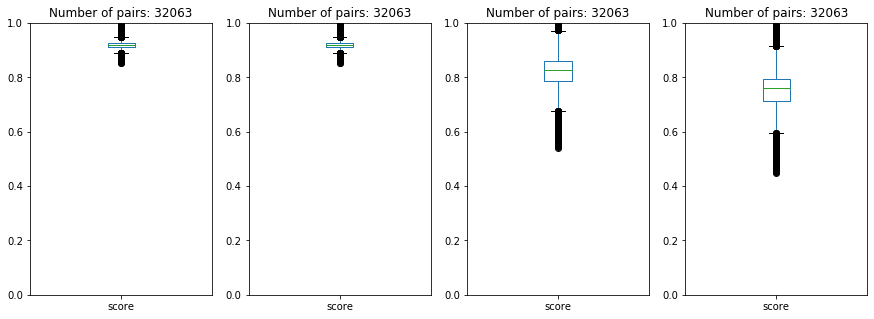

In [42]:
plt.figure(figsize=(15, 5))
plt.subplot(141)
b = boxplot_max_scores(aaa_type1_ballester, 'type1', 'ballester')
plt.subplot(142)
b = boxplot_max_scores(aaa_type1_eucl, 'type1', 'euclidean')
plt.subplot(143)
b = boxplot_max_scores(aaa_type2_ballester, 'type2', 'ballester')
plt.subplot(144)
b = boxplot_max_scores(aaa_type2_normballester, 'type2', 'normballester')

b.get_figure().savefig(
    path_to_similarities / f'similarity_scores_max.png', 
    dpi=300
)

## Get similarity matrix with best scoring kinase-pairs

In [79]:
get_similarity_matrix(aaa_type1_ballester, 'type1', 'ballester').head()

(253, 253)


kinase2,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
kinase1,,,,,,,,,,,,,,,,,,,,,
AAK1,0.989501,0.917881,0.913336,0.922638,0.911900,0.911304,0.899546,0.920456,0.918023,0.915555,...,0.914222,0.915142,0.900797,0.902804,0.908667,0.922879,0.919374,0.923606,0.928915,0.923389
ABL1,0.917881,0.989736,0.986733,0.941522,0.914404,0.918710,0.904596,0.911433,0.914611,0.952855,...,0.919521,0.936934,0.897035,0.893780,0.898714,0.924350,0.919331,0.920026,0.922953,0.923321
ABL2,0.913336,0.986733,NaN,0.939410,0.910460,0.914980,0.901269,0.910832,0.915372,0.947378,...,0.920843,0.931381,0.893092,0.892924,0.897125,0.926939,0.920063,0.915652,0.922701,0.918642
ACK,0.922638,0.941522,0.939410,0.993488,0.918524,0.919876,0.897695,0.909840,0.914415,0.940687,...,0.928429,0.946088,0.896611,0.897297,0.899516,0.920992,0.919763,0.918892,0.919558,0.916213
ACTR2,0.911900,0.914404,0.910460,0.918524,0.994356,0.980898,0.890012,0.903192,0.903783,0.910857,...,0.914983,0.909103,0.885934,0.884444,0.892557,0.914798,0.909205,0.914312,0.918697,0.907298


In [83]:
get_similarity_matrix(aaa_type1_eucl, 'type1', 'euclidean').head()

(253, 253)


kinase2,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
kinase1,,,,,,,,,,,,,,,,,,,,,
AAK1,0.989501,0.917881,0.913336,0.922638,0.911900,0.911304,0.899546,0.920456,0.918023,0.915555,...,0.914222,0.915142,0.900797,0.902804,0.908667,0.922879,0.919374,0.923606,0.928915,0.923389
ABL1,0.917881,0.989736,0.986733,0.941522,0.914404,0.918710,0.904596,0.911433,0.914611,0.952855,...,0.919521,0.936934,0.897035,0.893780,0.898714,0.924350,0.919331,0.920026,0.922953,0.923321
ABL2,0.913336,0.986733,NaN,0.939410,0.910460,0.914980,0.901269,0.910832,0.915372,0.947378,...,0.920843,0.931381,0.893092,0.892924,0.897125,0.926939,0.920063,0.915652,0.922701,0.918642
ACK,0.922638,0.941522,0.939410,0.993488,0.918524,0.919876,0.897695,0.909840,0.914415,0.940687,...,0.928429,0.946088,0.896611,0.897297,0.899516,0.920992,0.919763,0.918892,0.919558,0.916213
ACTR2,0.911900,0.914404,0.910460,0.918524,0.994356,0.980898,0.890012,0.903192,0.903783,0.910857,...,0.914983,0.909103,0.885934,0.884444,0.892557,0.914798,0.909205,0.914312,0.918697,0.907298


In [81]:
get_similarity_matrix(aaa_type2_ballester, 'type2', 'ballester').head()

(253, 253)


kinase2,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
kinase1,,,,,,,,,,,,,,,,,,,,,
AAK1,0.940327,0.824240,0.779826,0.804939,0.830494,0.820036,0.798212,0.850661,0.813062,0.800139,...,0.763527,0.828332,0.760280,0.719862,0.703993,0.884225,0.803030,0.826113,0.786576,0.841842
ABL1,0.824240,0.960868,0.961472,0.923160,0.785948,0.800226,0.750559,0.876263,0.871299,0.899114,...,0.800430,0.862713,0.824208,0.752025,0.737931,0.874864,0.852352,0.834766,0.861159,0.874032
ABL2,0.779826,0.961472,NaN,0.877725,0.761791,0.762477,0.720377,0.833859,0.848245,0.910019,...,0.793320,0.798851,0.759986,0.747861,0.735976,0.874615,0.824292,0.781139,0.833614,0.812052
ACK,0.804939,0.923160,0.877725,0.971757,0.781641,0.786971,0.733808,0.858579,0.881122,0.901101,...,0.817429,0.879289,0.814709,0.797527,0.764628,0.881310,0.852366,0.845425,0.873611,0.872290
ACTR2,0.830494,0.785948,0.761791,0.781641,0.977489,0.954881,0.767286,0.785883,0.760532,0.771640,...,0.743320,0.782422,0.709788,0.680509,0.673812,0.822446,0.758440,0.779418,0.780261,0.770242


In [43]:
get_similarity_matrix(aaa_type2_normballester, 'type2', 'normballester').head()

(253, 253)


kinase2,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
kinase1,,,,,,,,,,,,,,,,,,,,,
AAK1,0.933455,0.747709,0.702604,0.734339,0.755000,0.741484,0.710742,0.776347,0.734597,0.724131,...,0.689923,0.753527,0.679723,0.642566,0.630146,0.814343,0.732006,0.755970,0.721108,0.771379
ABL1,0.747709,0.954562,0.950548,0.869351,0.714035,0.731896,0.665595,0.795997,0.794133,0.856875,...,0.732069,0.805253,0.739367,0.663439,0.654422,0.806897,0.783203,0.764309,0.794433,0.805445
ABL2,0.702604,0.950548,NaN,0.826525,0.687415,0.692670,0.636966,0.755547,0.772450,0.863707,...,0.728721,0.742318,0.672915,0.660306,0.651551,0.811497,0.757107,0.710523,0.766872,0.742340
ACK,0.734339,0.869351,0.826525,0.967724,0.713955,0.720805,0.644470,0.775395,0.801627,0.845931,...,0.759030,0.833483,0.729018,0.713198,0.680738,0.810638,0.781320,0.772111,0.801215,0.797628
ACTR2,0.755000,0.714035,0.687415,0.713955,0.974079,0.938694,0.675506,0.700480,0.676458,0.695000,...,0.677994,0.704588,0.618294,0.588174,0.586119,0.753064,0.688446,0.708799,0.711239,0.690767
